# #1 K_Medoids (cdist DTW) with Tslearn

Aplicaremos el algoritmo K-Medoids, esta es la primera prueba de todas porque no queremos ni imputar datos ni interpolarlos queremos coger los cups con los datos que tiene. Para ello utilizamos la librería tslearn, con una métrica basada en DTW (Dynamic Time Warping). Esta combinación permite comparar series temporales que no están perfectamente alineadas en el tiempo (por ejemplo, viviendas cuyos consumos pueden estar desfasados o tener hábitos distintos de horario), y agruparlas en clústeres con patrones de consumo similares.

La métrica DTW es especialmente útil en este caso porque:

Permite comparar series temporales de distinta forma o fase, alineando picos y valles aunque ocurran en momentos diferentes.

No requiere que las viviendas tengan datos para exactamente las mismas fechas u horas.

Es robusta frente a pequeñas diferencias en el tiempo (por ejemplo, si dos viviendas consumen más por la noche, pero una empieza a las 22h y otra a las 23h).

In [1]:
%pip install --upgrade numpy
%pip uninstall -y tslearn
%pip install tslearn
import numpy as np
print(np.__version__)


  Using cached numpy-2.2.4-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.4-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2.2.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\tipir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Found existing installation: tslearn 0.6.3
Uninstalling tslearn-0.6.3:
  Successfully uninstalled tslearn-0.6.3
Note: you may need to restart the kernel to use updated packages.
  Using cached tslearn-0.6.3-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
Using cached tslearn-0.6.3-py3-none-any.whl (374 kB)
Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\tipir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


1.24.4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from joblib import dump

df = pd.read_csv("../../data/vertical_preprocessed_data.csv", sep=";")

import warnings
warnings.filterwarnings("ignore")

C:\Users\tipir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Definicion de las clases

Primero definimos las clases que van a formar nuestro pipeline, son 3 etapas: Preprocesamiento, seleccion del numero de cluster,ejecucion del clustering.

In [3]:
class ClusterSelection:
    def __init__(self, max_clusters=10):
        self.max_clusters = max_clusters

    def select_optimal_clusters(self, X):
        dist_matrix = cdist_dtw(X)

        silhouette_scores = []
        for k in range(2, self.max_clusters + 1):
            model = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
            labels = model.fit_predict(dist_matrix)
            score = silhouette_score(dist_matrix, labels, metric='precomputed')
            silhouette_scores.append(score)

        best_k = np.argmax(silhouette_scores) + 2
        print(f"🔎 Mejor número de clusters (Silhouette con DTW): {best_k}")

        # Plot opcional
        plt.plot(range(2, self.max_clusters + 1), silhouette_scores, marker='o')
        plt.title("Silhouette Score (DTW + K-Medoids)")
        plt.xlabel("Número de Clústeres")
        plt.ylabel("Silhouette Score")
        plt.grid(True)
        plt.show()

        return best_k

In [4]:
class TimeSeriesPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_sorted = X.sort_values(by=['cups', 'fecha', 'hora'])
        series_list = []

        for _, group in X_sorted.groupby('cups'):
            series = group['consumo_kWh'].values
            series_list.append(series)
        return series_list

In [5]:
class TimeSeriesClustering(BaseEstimator):
    def __init__(self, n_clusters=None):
        self.n_clusters = n_clusters
        self.cluster_selector = ClusterSelection()

    def fit(self, X, y=None):
        self.dist_matrix_ = cdist_dtw(X)

        if self.n_clusters is None:
            self.n_clusters = self.cluster_selector.select_optimal_clusters(X)

        self.model = KMedoids(n_clusters=self.n_clusters, metric='precomputed', random_state=42)
        self.labels_ = self.model.fit_predict(self.dist_matrix_)
        return self

    def transform(self, X):
        return self.labels_

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

🔎 Mejor número de clusters (Silhouette con DTW): 2


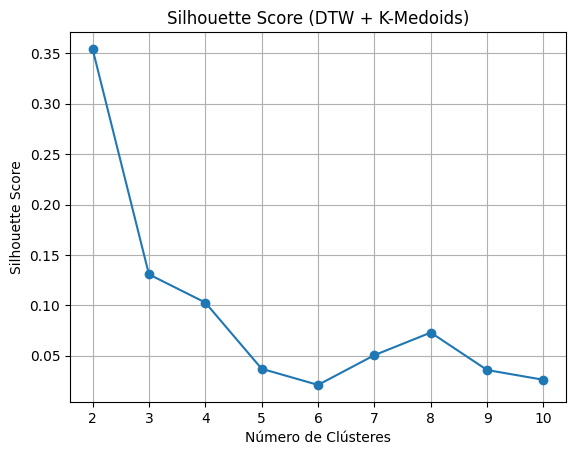

['modelo_kmedoids_entrenado.joblib']

In [6]:
pipeline = Pipeline([
    ('preprocessor', TimeSeriesPreprocessor()),
    ('clustering', TimeSeriesClustering(n_clusters=None)),
])

# === Ejecutar el pipeline ===
pipeline.fit_transform(df)

modelo_kmedoids = pipeline.named_steps['clustering'].model
dump(modelo_kmedoids, 'modelo_kmedoids_entrenado.joblib')